#### Base Settings

##### 데이터 출처
- [무료 레시피 데이터](https://kadx.co.kr/product/detail/0c5ec800-4fc2-11eb-8b6e-e776ccea3964)



In [ ]:
# !pip install transformers

##### Library

In [1]:
# Library import

## pandas
import pandas as pd

import gdown
import zipfile as zf
from tqdm import tqdm
import nltk

import os
import numpy as np
import matplotlib.pyplot as plt
import re
import json
from collections import Counter
import random

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Flatten, GlobalAveragePooling1D


import tensorflow_datasets as tfds

from transformers import ElectraTokenizer
from transformers import TFElectraModel

ModuleNotFoundError: ignored

###### Google Drive

In [ ]:
# # Google drive mout
# from google.colab import drive
# drive.mount('/content/drive')

### Data Preprocessing

#### Read

In [ ]:
def parsing_corpus(json_data, find_topic="정치"):
    topic_list = []
    title_list = []
    text_list = []

    for idx, doc in enumerate(json_data['document']):
        topic = json_data['document'][idx]["metadata"]["topic"]
        
        if re.search(find_topic, topic):
            topic_list.append(topic)
            title = json_data['document'][idx]["paragraph"][0]["form"]
            title_list.append(title)
            
            text = ""
            for i in range(len(json_data['document'][idx]["paragraph"][1:])):
                text += json_data['document'][idx]["paragraph"][i+1]["form"]+"\n"
        
            text_list.append(text)
    
    title_text_df = pd.DataFrame({"Topic" : topic_list, "Title" : title_list, "Text" : text_list})

    return title_text_df

In [ ]:
# news_2019 = "https://drive.google.com/file/d/1ja_vUSuIcN37YufRh1TyZUBAcW4r4H1X/view?usp=sharing"
# news_2020 = "https://drive.google.com/file/d/1jgUEQSxiN4jaSDxQvodCRrY1LlsCVPrd/view?usp=sharing"
# news_2021 = "https://drive.google.com/file/d/1jeP5QVRkX-YZJI8xx0UQ5sAWzTwPHVK_/view?usp=sharing"
# news_2022 = "https://drive.google.com/file/d/1jcw4UoeUjTK-VeeCuxDB5fBZbHdSUxY0/view?usp=sharing"

# zip_list = [news_2019, news_2020, news_2021, news_2022]

# zip_list = ["NIKLNEWSPAPER_2022_v1.0.zip",
#             "NIKL_NEWSPAPER_v2.0.zip",
#             "NIKL_NEWSPAPER_2021_v1.0.zip",
#             "NIKL_NEWSPAPER_2020_v1.1.zip"]

# for idx, file_name in enumerate(zip_list):
    
#     # 압축풀기
#     files = zf.ZipFile(file_name, 'r')
#     files.extractall("data/")
#     files.close()

In [ ]:
def collect_json_file(path):
    """
    폴더의 json파일을 모두 불러와 리스트로 반환하는 함수
    """
    file_list = os.listdir(path)

    json_list = []
    for file_name in file_list:
        if '.json' in file_name:
            json_list.append(file_name)

    return json_list

In [ ]:
random.seed(83)
rnad_num = 7

json_dir = "./data/"
json_list = collect_json_file(json_dir)
json_list = random.sample(json_list, rnad_num)

In [ ]:
with tqdm(total=len(json_list)) as pbar:
    df = pd.DataFrame()
    for idx, j_file in enumerate(json_list):
        with open("data/"+j_file) as f:
            js = json.loads(f.read())
        parsed_df = parsing_corpus(js, "정치")
        df = pd.concat([df,parsed_df])
        pbar.update()

100%|██████████| 7/7 [00:02<00:00,  2.56it/s]


In [ ]:
print(df.shape)
df.sample(5)

(11815, 3)


,Topic,Title,Text
5342,정치,"나경원, 與 향해 ""내가 조국처럼 살았나…이 모든 것은 치졸한 복수""",검찰이 자녀 ‘입시 비리’ 의혹 등으로 민생경제연구소 등 시민단체로부터 고발된 나경...
1113,정치,"김기현 첫 비대위 주재 “백신·집값·세금·일자리, 대여 민생투쟁 나설 것”",김기현 국민의힘 당대표 권한대행 겸 원내대표가 3일 문재인 정부와 더불어민주당을 향...
4262,정치,공정위 최고 단골 손님은 '김앤장'…7월까지 440번 접촉,국내 최대 로펌인 김앤장이 올 들어 공정거래위원회에 400회 넘게 접촉한 것으로 나...
3986,정치,"최재성 靑 정무수석 ""秋 아들 의혹, 검찰 수사 지켜보는 것이 해답""",최재성 청와대 정무수석이 15일 추미애 법무부 장관 아들의 군 복무 시절 특혜 논란...
1871,정치,"국민의힘, 대선 경선 2단계 컷오프 확정...1차 8인→2차 4인 압축",국민의힘은 3일 대선 후보 경선 과정에서 2번의 컷오프(탈락)를 통해 최종 4인의 ...


In [ ]:
df.columns = ["Topic","Q","A"]
train_data = df.copy()

### Model Function

In [2]:
# 최종 버전
class PositionalEncoding(tf.keras.layers.Layer):
  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)

    # 배열의 짝수 인덱스(2i)에는 사인 함수 적용
    sines = tf.math.sin(angle_rads[:, 0::2])

    # 배열의 홀수 인덱스(2i+1)에는 코사인 함수 적용
    cosines = tf.math.cos(angle_rads[:, 1::2])

    angle_rads = np.zeros(angle_rads.shape)
    angle_rads[:, 0::2] = sines
    angle_rads[:, 1::2] = cosines
    pos_encoding = tf.constant(angle_rads)
    pos_encoding = pos_encoding[tf.newaxis, ...]

    print(pos_encoding.shape)
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

(1, 200, 128)


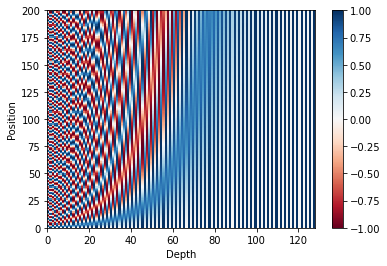

In [26]:
sample_pos_encoding = PositionalEncoding(200, 128)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 128))
plt.ylabel('Position')
plt.colorbar()
plt.show()

In [ ]:
def scaled_dot_product_attention(query, key, value, mask):
  # query 크기 : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
  # key 크기 : (batch_size, num_heads, key의 문장 길이, d_model/num_heads)
  # value 크기 : (batch_size, num_heads, value의 문장 길이, d_model/num_heads)
  # padding_mask : (batch_size, 1, 1, key의 문장 길이)

  # Q와 K의 곱. 어텐션 스코어 행렬.
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 스케일링
  # dk의 루트값으로 나눠준다.
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 마스킹. 어텐션 스코어 행렬의 마스킹 할 위치에 매우 작은 음수값을 넣는다.
  # 매우 작은 값이므로 소프트맥스 함수를 지나면 행렬의 해당 위치의 값은 0이 된다.
  if mask is not None:
    logits += (mask * -1e9)

  # 소프트맥스 함수는 마지막 차원인 key의 문장 길이 방향으로 수행된다.
  # attention weight : (batch_size, num_heads, query의 문장 길이, key의 문장 길이)
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # output : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
  output = tf.matmul(attention_weights, value)

  return output, attention_weights

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    # d_model을 num_heads로 나눈 값.
    # 논문 기준 : 64
    self.depth = d_model // self.num_heads

    # WQ, WK, WV에 해당하는 밀집층 정의
    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    # WO에 해당하는 밀집층 정의
    self.dense = tf.keras.layers.Dense(units=d_model)

  # num_heads 개수만큼 q, k, v를 split하는 함수
  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # 1. WQ, WK, WV에 해당하는 밀집층 지나기
    # q : (batch_size, query의 문장 길이, d_model)
    # k : (batch_size, key의 문장 길이, d_model)
    # v : (batch_size, value의 문장 길이, d_model)
    # 참고) 인코더(k, v)-디코더(q) 어텐션에서는 query 길이와 key, value의 길이는 다를 수 있다.
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # 2. 헤드 나누기
    # q : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
    # k : (batch_size, num_heads, key의 문장 길이, d_model/num_heads)
    # v : (batch_size, num_heads, value의 문장 길이, d_model/num_heads)
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # 3. 스케일드 닷 프로덕트 어텐션. 앞서 구현한 함수 사용.
    # (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
    scaled_attention, _ = scaled_dot_product_attention(query, key, value, mask)
    # (batch_size, query의 문장 길이, num_heads, d_model/num_heads)
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 4. 헤드 연결(concatenate)하기
    # (batch_size, query의 문장 길이, d_model)
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # 5. WO에 해당하는 밀집층 지나기
    # (batch_size, query의 문장 길이, d_model)
    outputs = self.dense(concat_attention)

    return outputs

In [ ]:
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, key의 문장 길이)
  return mask[:, tf.newaxis, tf.newaxis, :]

In [ ]:
def encoder_layer(dff, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

  # 인코더는 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 멀티-헤드 어텐션 (첫번째 서브층 / 셀프 어텐션)
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs, 'key': inputs, 'value': inputs, # Q = K = V
          'mask': padding_mask # 패딩 마스크 사용
      })

  # 드롭아웃 + 잔차 연결과 층 정규화
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  # 포지션 와이즈 피드 포워드 신경망 (두번째 서브층)
  outputs = tf.keras.layers.Dense(units=dff, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 드롭아웃 + 잔차 연결과 층 정규화
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [ ]:
def encoder(vocab_size, num_layers, dff,
            d_model, num_heads, dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 인코더는 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 포지셔널 인코딩 + 드롭아웃
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # 인코더를 num_layers개 쌓기
  for i in range(num_layers):
    outputs = encoder_layer(dff=dff, d_model=d_model, num_heads=num_heads,
        dropout=dropout, name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [ ]:
# 디코더의 첫번째 서브층(sublayer)에서 미래 토큰을 Mask하는 함수
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x) # 패딩 마스크도 포함
  return tf.maximum(look_ahead_mask, padding_mask)

In [ ]:
def decoder_layer(dff, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")

  # 디코더는 룩어헤드 마스크(첫번째 서브층)와 패딩 마스크(두번째 서브층) 둘 다 사용.
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 멀티-헤드 어텐션 (첫번째 서브층 / 마스크드 셀프 어텐션)
  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs, 'key': inputs, 'value': inputs, # Q = K = V
          'mask': look_ahead_mask # 룩어헤드 마스크
      })

  # 잔차 연결과 층 정규화
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  # 멀티-헤드 어텐션 (두번째 서브층 / 디코더-인코더 어텐션)
  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1, 'key': enc_outputs, 'value': enc_outputs, # Q != K = V
          'mask': padding_mask # 패딩 마스크
      })

  # 드롭아웃 + 잔차 연결과 층 정규화
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  # 포지션 와이즈 피드 포워드 신경망 (세번째 서브층)
  outputs = tf.keras.layers.Dense(units=dff, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 드롭아웃 + 잔차 연결과 층 정규화
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

In [ ]:
def decoder(vocab_size, num_layers, dff,
            d_model, num_heads, dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')

  # 디코더는 룩어헤드 마스크(첫번째 서브층)와 패딩 마스크(두번째 서브층) 둘 다 사용.
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 포지셔널 인코딩 + 드롭아웃
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # 디코더를 num_layers개 쌓기
  for i in range(num_layers):
    outputs = decoder_layer(dff=dff, d_model=d_model, num_heads=num_heads,
        dropout=dropout, name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

In [ ]:
def transformer(vocab_size, num_layers, dff,
                d_model, num_heads, dropout,
                name="transformer"):

  # 인코더의 입력
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 디코더의 입력
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  # 인코더의 패딩 마스크
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # 디코더의 룩어헤드 마스크(첫번째 서브층)
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask, output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

  # 디코더의 패딩 마스크(두번째 서브층)
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  # 인코더의 출력은 enc_outputs. 디코더로 전달된다.
  enc_outputs = encoder(vocab_size=vocab_size, num_layers=num_layers, dff=dff,
      d_model=d_model, num_heads=num_heads, dropout=dropout,
  )(inputs=[inputs, enc_padding_mask]) # 인코더의 입력은 입력 문장과 패딩 마스크

  # 디코더의 출력은 dec_outputs. 출력층으로 전달된다.
  dec_outputs = decoder(vocab_size=vocab_size, num_layers=num_layers, dff=dff,
      d_model=d_model, num_heads=num_heads, dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # 다음 단어 예측을 위한 출력층
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

In [ ]:
small_transformer = transformer(
    vocab_size = 9000,
    num_layers = 6,
    dff = 512,
    d_model = 128,
    num_heads = 4,
    dropout = 0.3,
    name="small_transformer")

tf.keras.utils.plot_model(
    small_transformer, to_file='small_transformer.png', show_shapes=True)

(1, 9000, 128)
(1, 9000, 128)
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [ ]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))

  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()
    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)
    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [ ]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

Text(0.5, 0, 'Train Step')

### Chat

In [ ]:
print('챗봇 샘플의 개수 :', len(train_data))

챗봇 샘플의 개수 : 11815


In [ ]:
print(train_data.isnull().sum())

Topic    0
Q        0
A        0
dtype: int64


In [ ]:
questions = []
for sentence in train_data['Q']:
    # 구두점에 대해서 띄어쓰기
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = sentence.strip()
    questions.append(sentence)

answers = []
for sentence in train_data['A']:
    # 구두점에 대해서 띄어쓰기
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = sentence.strip()
    answers.append(sentence)

In [ ]:
len(questions)

11815

In [ ]:
print(questions[:2])
print(answers[:2])

['정준호 “정계진출 ?  언젠가는∼” 선거때마다 수차례 영입 제의', '가능성에 집중하라 !']
['배우 정준호가 정계 진출에 대한 자신의 솔직한 생각을 밝혔다 . \n정준호는 활발한 사회봉사 활동을 벌이고 있고 정관계 인사들과 친분이 두터워 정계로부터 수차례 영입 제의를 받기도 했다 . \n국회의원 선거가 있을 때마다 일부에서는 고향인 충청남도에서 출마를 준비하고 있다는 섣부른 전망을 내놓기도 했다 . \n정준호는 최근 스포츠동아와 만나 이에 관한 질문을 받고 “증권가 사설 정보지에 ‘정준호가 국회의원 출마를 준비하고 있다’는 내용이 자주 나온다고 한다”고 웃으며 “구체적인 계획을 세워본 적은 없다”고 선을 그었다 . \n하지만 “시골에서 태어나 이웃을 돕고 ,  함께 나누는 일을 자연스럽게 받아들이면서 자랐다 .  그래서 ‘사랑의 밥차’도 운영하고 봉사활동 단체도 이끌고 있다 . \n나중에 정말로 국민들께 더 봉사할 수 있는 기회가 생긴다면 해보고 싶다”고 밝혔다 . \n또 “친분이 있는 국회의원들이 나중에 내 지역구에서는 절대 나오지 말라고 농담을 한다 .  한 번 맺은 인연을 소중하게 생각하고 많은 분들과 교류하며 돕는 걸 즐겁게 생각하다 보니 다양한 분야에서 좋은 분들을 만나고 있다”며 웃었다 . \n제작자로 변신해 주연까지 맡은 코미디 액션 영화 ‘유감스러운 도시’의 22일 개봉을 앞둔 정준호는 평소 절친하게 지내고 있는 정관계 인사들의 도움을 많이 받아 제작비도 아끼고 넓은 장소도 섭외할 수 있었다고 설명했다 . \n하지만 정준호는 당분간은 연기와 봉사활동 그리고 제작에만 전념할 계획이다 . \n그는 “주변에 능력있는 감독 ,  작가 ,  스태프들 그리고 참신한 후배 연기자들이 참 많다 .  그들이 좋은 작품과 만나 영화를 선보일 수 있는 시스템을 만들고 싶다”고 말했다 .', '1912년 ,  미국 대통령 선거를 앞두고\n시어도어 루스벨트 전직 대통령은 정계복귀를 선언합니다 . \n선거전이 점점 치열해져 가고 있던 시점에\n루스벨트 캠프에는 생

In [ ]:
%%time
# 서브워드텍스트인코더를 사용하여 질문과 답변을 모두 포함한 단어 집합(Vocabulary) 생성
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    questions + answers, target_vocab_size=10000)

# 시작 토큰과 종료 토큰에 대한 정수 부여.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

# 시작 토큰과 종료 토큰을 고려하여 단어 집합의 크기를 + 2
VOCAB_SIZE = tokenizer.vocab_size + 2

CPU times: user 3min 57s, sys: 988 ms, total: 3min 58s
Wall time: 3min 59s


In [ ]:
print('시작 토큰 번호 :',START_TOKEN)
print('종료 토큰 번호 :',END_TOKEN)
print('단어 집합의 크기 :',VOCAB_SIZE)

시작 토큰 번호 : [9943]
종료 토큰 번호 : [9944]
단어 집합의 크기 : 9945


In [ ]:
# 서브워드텍스트인코더 토크나이저의 .encode()를 사용하여 텍스트 시퀀스를 정수 시퀀스로 변환.
print('Tokenized sample question: {}'.format(tokenizer.encode(questions[0])))

Tokenized sample question: [82, 478, 236, 3, 4961, 2657, 2005, 597, 3568, 58, 95, 1828, 1617, 299, 5635, 8987, 8554, 7390]


In [ ]:
# 서브워드텍스트인코더 토크나이저의 .encode()와 decode() 테스트해보기

# 임의의 입력 문장을 sample_string에 저장
sample_string = questions[0]

# encode() : 텍스트 시퀀스 --> 정수 시퀀스
tokenized_string = tokenizer.encode(sample_string)
print ('정수 인코딩 후의 문장 {}'.format(tokenized_string))

# decode() : 정수 시퀀스 --> 텍스트 시퀀스
original_string = tokenizer.decode(tokenized_string)
print ('기존 문장: {}'.format(original_string))

정수 인코딩 후의 문장 [82, 478, 236, 3, 4961, 2657, 2005, 597, 3568, 58, 95, 1828, 1617, 299, 5635, 8987, 8554, 7390]
기존 문장: 정준호 “정계진출 ?  언젠가는∼” 선거때마다 수차례 영입 제의


In [ ]:
# 각 정수는 각 단어와 어떻게 mapping되는지 병렬로 출력
# 서브워드텍스트인코더는 의미있는 단위의 서브워드로 토크나이징한다. 띄어쓰기 단위 X 형태소 분석 단위 X
for ts in tokenized_string:
    print ('{} ----> {}'.format(ts, tokenizer.decode([ts])))

82 ----> 정
478 ----> 준
236 ----> 호
3 ---->  “
4961 ----> 정계
2657 ----> 진출
2005 ---->  ?  
597 ----> 언
3568 ----> 젠
58 ----> 가
95 ----> 는
1828 ----> ∼
1617 ----> ” 
299 ----> 선거
5635 ----> 때마다 
8987 ----> 수차례 
8554 ----> 영입 
7390 ----> 제의


In [ ]:
# 최대 길이
MAX_LENGTH = 200

# 토큰화 / 정수 인코딩 / 시작 토큰과 종료 토큰 추가 / 패딩
def tokenize_and_filter(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []
    
    with tqdm(total=len(inputs)) as pbar:

        for (sentence1, sentence2) in zip(inputs, outputs):
            # encode(토큰화 + 정수 인코딩), 시작 토큰과 종료 토큰 추가
            sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
            sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

            tokenized_inputs.append(sentence1)
            tokenized_outputs.append(sentence2)
            
            pbar.update()

        # 패딩
        tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
                            tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
        tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
                            tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
        
        

    return tokenized_inputs, tokenized_outputs

In [ ]:
questions, answers = tokenize_and_filter(questions, answers)

100%|██████████| 11815/11815 [00:10<00:00, 1146.44it/s]


In [ ]:
print('질문 데이터의 크기(shape) :', questions.shape)
print('답변 데이터의 크기(shape) :', answers.shape)

질문 데이터의 크기(shape) : (11815, 200)
답변 데이터의 크기(shape) : (11815, 200)


In [ ]:
# 0번째 샘플을 임의로 출력
print(questions[0])
print(answers[0])

[9943   82  478  236    3 4961 2657 2005  597 3568   58   95 1828 1617
  299 5635 8987 8554 7390 9944    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0 

In [ ]:
print('단어 집합의 크기(Vocab size): {}'.format(VOCAB_SIZE))
print('전체 샘플의 수(Number of samples): {}'.format(len(questions)))

단어 집합의 크기(Vocab size): 9945
전체 샘플의 수(Number of samples): 11815


In [ ]:
# 텐서플로우 dataset을 이용하여 셔플(shuffle)을 수행하되, 배치 크기로 데이터를 묶는다.
# 또한 이 과정에서 교사 강요(teacher forcing)을 사용하기 위해서 디코더의 입력과 실제값 시퀀스를 구성한다.
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더의 실제값 시퀀스에서는 시작 토큰을 제거해야 한다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1] # 디코더의 입력. 마지막 패딩 토큰이 제거된다.
    },
    {
        'outputs': answers[:, 1:]  # 맨 처음 토큰이 제거된다. 다시 말해 시작 토큰이 제거된다.
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
# 임의의 샘플에 대해서 [:, :-1]과 [:, 1:]이 어떤 의미를 가지는지 테스트해본다.
print(answers[0]) # 기존 샘플
print(answers[:1][:, :-1]) # 마지막 패딩 토큰 제거하면서 길이가 39가 된다.
print(answers[:1][:, 1:]) # 맨 처음 토큰이 제거된다. 다시 말해 시작 토큰이 제거된다. 길이는 역시 39가 된다.

[5782 8090 4036 3700    7 1772    2    7   59    4  462    3  892 2954
   41 4779    8   96 2267  320 6481  508 4240 8272 2885    7  949 9005
   33    1   13  947 5705   14 6963    6 7016  135 7632  375 1375   16
 3586  533 4674   10 1644 9923 9853 9831 3430   49 2786  297 3118  990
 6038 1105 1375    6  723    7   20    2   53 2439  294    4 5823 2385
  644  129   48  131  209   66 5073 1044  133 6228  951 7190 8983   17
 5992 3571  607   25   11 1528  252  738    6 3280   82  478  236   10
  472 1221  734  892  135 8837    7   41   82 1945 2184   11 6268    6
  659 2170 5823  107   19 9630    7 2606   14 4479   19 2626  486   22
   27  679    7  217    4  275   82  478  236   10  221  267  439   14
 1874   31 3661 3112 1498 5823 2853   90 3828   22  802    4  144    3
 3229    9 3908   41 2920    5  711   58    5  125  306 1724 1523 1498
 1381 6107 9719  419  984 1874 6962 3162 1459    1 2994    8 1105  711
 1110   16 1583 8983   12  173 8197 9719   27   41 6292 5521 1772    2
    7 

In [ ]:
tf.keras.backend.clear_session()

# Hyper-parameters
NUM_LAYERS = 3
D_MODEL = 256
NUM_HEADS = 8
DFF = 512
DROPOUT = 0.1

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    dff=DFF,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

(1, 9945, 256)
(1, 9945, 256)


In [ ]:
MAX_LENGTH = 200

learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  # ensure labels have shape (batch_size, MAX_LENGTH - 1)
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [ ]:
%%time
EPOCHS = 50
model.fit(dataset, epochs=EPOCHS)

Epoch 1/50
185/185 [==============================] - 100s 432ms/step - loss: 8.8880 - accuracy: 0.0230
Epoch 2/50
185/185 [==============================] - 66s 356ms/step - loss: 7.9964 - accuracy: 0.0373
Epoch 3/50
185/185 [==============================] - 64s 347ms/step - loss: 7.3378 - accuracy: 0.0907
Epoch 4/50
185/185 [==============================] - 64s 345ms/step - loss: 6.5777 - accuracy: 0.1245
Epoch 5/50
185/185 [==============================] - 64s 344ms/step - loss: 6.0935 - accuracy: 0.1447
Epoch 6/50
185/185 [==============================] - 64s 344ms/step - loss: 5.7652 - accuracy: 0.1629
Epoch 7/50
185/185 [==============================] - 64s 348ms/step - loss: 5.5011 - accuracy: 0.1788
Epoch 8/50
185/185 [==============================] - 64s 344ms/step - loss: 5.2781 - accuracy: 0.1911
Epoch 9/50
185/185 [==============================] - 64s 343ms/step - loss: 5.0741 - accuracy: 0.2022
Epoch 10/50
185/185 [==============================] - 64s 343ms/step - 

In [ ]:
def evaluate(sentence):
  sentence = preprocess_sentence(sentence)

  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  output = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 예측 시작
  for i in range(MAX_LENGTH):
    predictions = model(inputs=[sentence, output], training=False)

    # 현재(마지막) 시점의 예측 단어를 받아온다.
    predictions = predictions[:, -1:, :]
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 마지막 시점의 예측 단어가 종료 토큰이라면 예측을 중단
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # 마지막 시점의 예측 단어를 출력에 연결한다.
    # 이는 for문을 통해서 디코더의 입력으로 사용될 예정이다.
    output = tf.concat([output, predicted_id], axis=-1)

  return tf.squeeze(output, axis=0)


def predict(sentence):
  prediction = evaluate(sentence)

  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('Input: {}'.format(sentence))
  print('Output: {}'.format(predicted_sentence))

  return predicted_sentence

In [ ]:
def preprocess_sentence(sentence):
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
  sentence = sentence.strip()
  return sentence

In [ ]:
%%time
output = predict('이연준, 대통령상 수상')

In [ ]:
%%time
output = predict('안철수 대통령 당선')